In [1]:
# Import useful libraries.
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib notebook
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

# Global variables.
log_period_samples = 20000
batch_size = 100

# Import dataset with one-hot encoding of the class labels.
def get_data():
  return input_data.read_data_sets("MNIST_data/", one_hot=True)

# Placeholders to feed train and test data into the graph.
# Since batch dimension is 'None', we can reuse them both for train and eval.
def get_placeholders():
  x = tf.placeholder(tf.float32, [None, 784])
  y_ = tf.placeholder(tf.float32, [None, 784])
  return x, y_

# Plot learning curves of experiments
def plot_learning_curves(experiment_data):
  # Generate figure.
  fig, axes = plt.subplots(3, 4, figsize=(22,12))
  st = fig.suptitle(
      "Learning Curves for all Tasks and Hyper-parameter settings",
      fontsize="x-large")
  # Plot all learning curves.
  for i, results in enumerate(experiment_data):
    for j, (setting, train_accuracy, test_accuracy) in enumerate(results):
      # Plot.
      xs = [x * log_period_samples for x in range(1, len(train_accuracy)+1)]
      axes[j, i].plot(xs, train_accuracy, label='train_accuracy')
      axes[j, i].plot(xs, test_accuracy, label='test_accuracy')
      # Prettify individual plots.
      axes[j, i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
      axes[j, i].set_xlabel('Number of samples processed')
      axes[j, i].set_ylabel('Epochs: {}, Learning rate: {}.  Accuracy'.format(*setting))
      axes[j, i].set_title('Task {}'.format(i + 1))
      axes[j, i].legend()
  # Prettify overall figure.
  plt.tight_layout()
  st.set_y(0.95)
  fig.subplots_adjust(top=0.91)
  plt.show()

# Generate summary table of results.
def plot_summary_table(experiment_data):
  # Fill Data.
  cell_text = []
  rows = []
  columns = ['Setting 1', 'Setting 2', 'Setting 3']
  for i, results in enumerate(experiment_data):
    rows.append('Model {}'.format(i + 1))
    cell_text.append([])
    for j, (setting, train_accuracy, test_accuracy) in enumerate(results):
      cell_text[i].append(test_accuracy[-1])
  # Generate Table.
  fig=plt.figure(frameon=False)
  ax = plt.gca()
  the_table = ax.table(
      cellText=cell_text,
      rowLabels=rows,
      colLabels=columns,
      loc='center')
  the_table.scale(1, 4)
  # Prettify.
  ax.patch.set_facecolor('None')
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)

In [2]:
class Counter:
  def __init__(self, batch_size, data_size):
    self.shuffled = np.arange(data_size)
    np.random.shuffle(self.shuffled)     
    self.current_epoch = 0
    self.current_batch = 0
    self.data_size = data_size
    self.batch_size = batch_size
    
  def indices(self):
    next = self.current_batch + self.batch_size
    if next <= self.data_size:
      indices = self.shuffled[np.arange(self.current_batch, next)]
      self.current_batch += self.batch_size
    else:
      self.current_epoch += 1
      if self.current_batch < self.data_size:
        indices = self.shuffled[np.arange(self.current_batch, self.data_size)]
        self.current_batch = 0    
        np.random.shuffle(self.shuffled)          
      else: 
        np.random.shuffle(self.shuffled)  
        indices = self.shuffled[np.arange(0, self.batch_size)]
        self.current_batch = self.batch_size

    return indices, self.current_epoch

def show_prediction(image_original, image_noisy, Weights, sample_index):  
  plt.figure(figsize=(8,4))
  image_predicted = np.matmul((np.matmul(image_noisy[sample_index], Weights[0])+Weights[2]),Weights[1])+Weights[3]
  plt.subplot(131)
  plt.imshow(image_noisy[sample_index].reshape(28,28), cmap='Greys')
  plt.title('Noisy image')

  plt.subplot(132)
  plt.imshow(image_predicted.reshape(28,28), cmap='Greys')
  plt.title('Predicted image')

  plt.subplot(133)
  plt.imshow(image_original[sample_index].reshape(28,28), cmap='Greys')
  plt.title('Original image')
  plt.show()

def generate_noisy_images(image_original, isotropic_gaussian_sd, masking_v, salt_and_pepper_v):
  
  image_isotropic_gaussian = image_original.copy()
  image_masking = image_original.copy()
  image_salt_and_pepper = image_original.copy()
  
  # Assign random values between 0 and 1 for assigning later
  noise_pixels = np.random.uniform(size=image_original.shape) 
    
  # Isotropic gaussian: add a gaussian noise to all pixels
  image_isotropic_gaussian += np.random.normal(loc=np.mean(image_original), scale=isotropic_gaussian_sd, size=image_original.shape)
    
  # Masking: Assign the proportion v as 0
  image_masking[noise_pixels<float(masking_v/2)] = 0
  
  # Salt and pepper: Assign half of proportion v as 1, half of proportion as 0 and leave the rest
  image_salt_and_pepper[noise_pixels<float(salt_and_pepper_v/2)] = 0
  image_salt_and_pepper[noise_pixels>1-float(salt_and_pepper_v/2) ] = 1  
   
  return image_isotropic_gaussian, image_masking, image_salt_and_pepper

def show_samples(image_original, image_isotropic_gaussian, image_masking, image_salt_and_pepper, sample_index):
  # Display a sample
  plt.figure(figsize=(8,4))
  plt.subplot(141)
  plt.imshow(image_original[sample_index].reshape(28,28), cmap='Greys')
  plt.title('Original image')

  plt.subplot(142)
  plt.imshow(image_isotropic_gaussian[sample_index].reshape(28,28), cmap='Greys')
  plt.title('Isotropic gaussian noise')

  plt.subplot(143)
  plt.imshow(image_masking[sample_index].reshape(28,28), cmap='Greys')
  plt.title('Masking noise')

  plt.subplot(144)
  plt.imshow(image_salt_and_pepper[sample_index].reshape(28,28), cmap='Greys')
  plt.title('Salt and pepper noise')
  plt.tight_layout()
  plt.plot()

In [3]:
image_original = get_data()
image_original_train = image_original.train.images
image_original_test = image_original.test.images

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
image_isotropic_gaussian_train, image_masking_train, image_salt_and_pepper_train = generate_noisy_images(image_original_train, isotropic_gaussian_sd=0.15, masking_v=0.1, salt_and_pepper_v=0.1)

image_isotropic_gaussian_test, image_masking_test, image_salt_and_pepper_test = generate_noisy_images(image_original_test, isotropic_gaussian_sd=0.15, masking_v=0.1, salt_and_pepper_v=0.1)

<IPython.core.display.Javascript object>


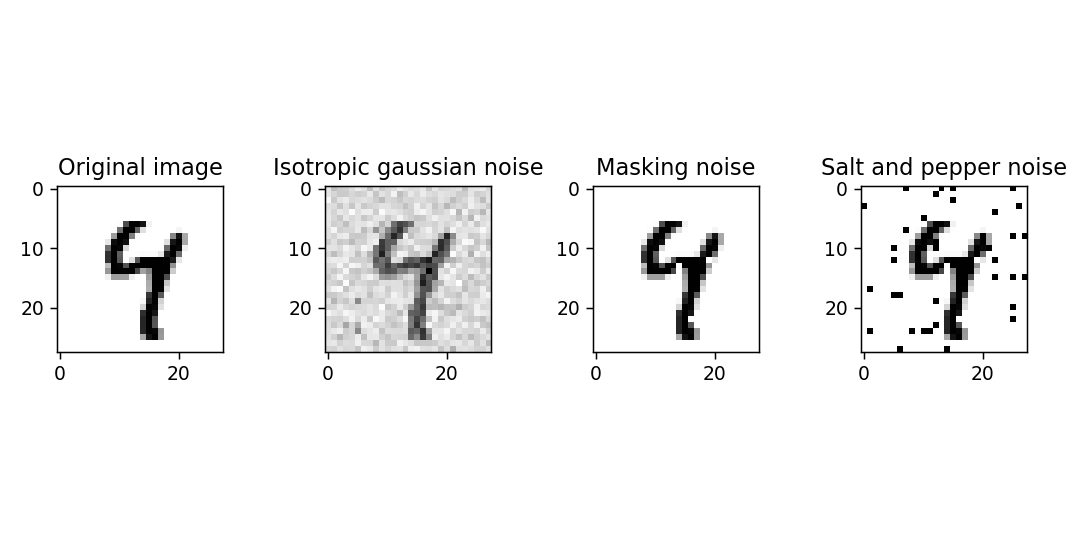

In [5]:
sample_index = 2
show_samples(image_original_train, image_isotropic_gaussian_train, image_masking_train, image_salt_and_pepper_train, sample_index)

<IPython.core.display.Javascript object>


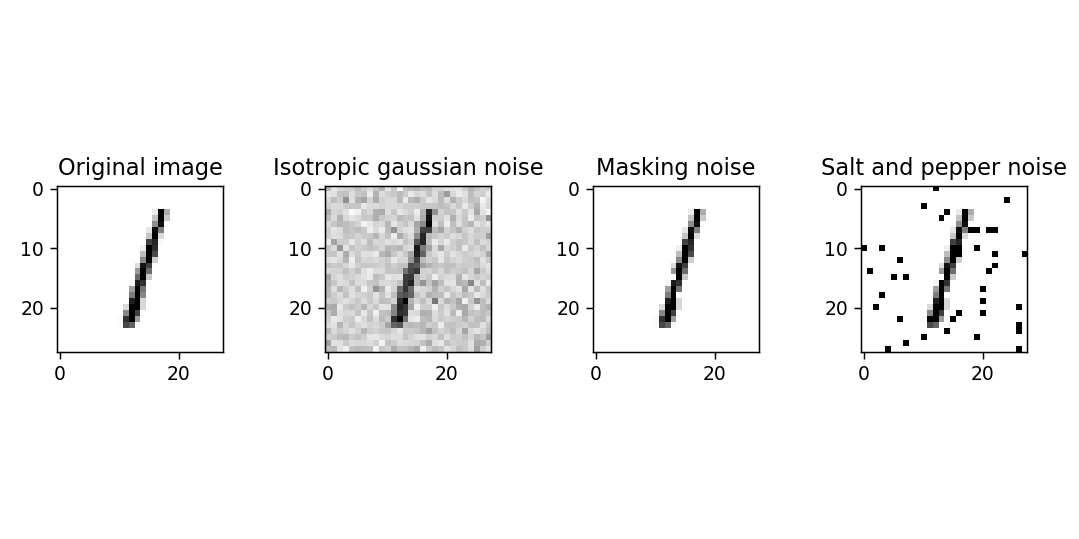

In [6]:
sample_index = 2
show_samples(image_original_test, image_isotropic_gaussian_test, image_masking_test, image_salt_and_pepper_test, sample_index)

In [7]:
def autoencoder(image_original_train, image_original_test, image_noisy_train, image_noisy_test, num_epochs, learning_rate, hidden_size, early_break_period, sample_index=0):
  fig = plt.figure(figsize=(8.5,10))
  current_epoch = 0
  init = True
  early_break_loss = 10**10
  
  # Train Model 1 with the different hyper-parameter settings.
  # Reset graph, recreate placeholders and dataset.
  tf.reset_default_graph()
  x, y_ = get_placeholders()
  # mnist = get_data()
  # eval_mnist = get_data()

  #####################################################
  # Define model, loss, update and evaluation metric. #
  #####################################################

  image_size = image_original_train.shape[1]

  # Initialise weights with xavier
  initializer = tf.contrib.layers.xavier_initializer()
  W1 = tf.Variable(initializer([image_size, hidden_size]))
  W2 = tf.Variable(initializer([hidden_size, image_size]))
  # Biases are usually initialised with zeros
  B1 = tf.Variable(tf.zeros([hidden_size]))  
  B2 = tf.Variable(tf.zeros([image_size]))

  # Layer operations
  h = tf.matmul(x, W1) + B1
  y = tf.matmul(h, W2) + B2

  # Note that although reduce_mean is what would be usally used, reduce_sum has
  # been used here. Since the batch size is constant, this is equivalent of
  # multiplying the learning rate by the batch size.
  cross_entropy = tf.reduce_sum(
      tf.losses.mean_squared_error(labels=y_, predictions=y)
  )

  train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
  
  counter = Counter(batch_size, image_original_train.shape[0])
  # Train.
  i, train_losses, test_losses = 0, [], []
  log_period_updates = int(log_period_samples / batch_size)
  with tf.train.MonitoredSession() as sess:
    while counter.current_epoch < num_epochs:

      # Update.
      i += 1
      indices, epoch = counter.indices()
      
      batch_xs = image_noisy_train[indices]
      batch_ys = image_original_train[indices]

      #################
      # Training step #
      #################      
      
      sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

      # Periodically evaluate.
      if init or not current_epoch == epoch:
#         print(epoch)
        init = False
        current_epoch = epoch
        #####################################
        # Compute and store train accuracy. #
        #####################################

        # Get a fifth of a shuffled indices of the images
        indices = np.arange(image_original_train.shape[0])
        np.random.shuffle(indices)     
        indices_fifth = indices[:int(len(indices) * 0.2)]

        # Calculate the accuracy and append it to train_accuracy
        loss_train = sess.run(
            cross_entropy,
            feed_dict={
                x: image_noisy_train[indices_fifth],
                y_: image_original_train[indices_fifth]
            }
        )

        train_losses.append(loss_train)

        #####################################
        # Compute and store test accuracy.  #
        #####################################

        loss_test = sess.run(
            cross_entropy, feed_dict={
                x: image_noisy_test,
                y_: image_original_test
            }
        )

        test_losses.append(loss_test)
        
        # Early break
#         print(np.log(loss_test), np.log(early_break_loss))
        if current_epoch%early_break_period == 0:
          if np.log(loss_test) >= np.log(early_break_loss):
            return print('Early broke')
          else:
            early_break_loss = loss_test
        
        image_predicted_test = sess.run(y, feed_dict={x:[image_original_test[sample_index]]})
        
        grid = plt.GridSpec(2, 3)
        plt.subplot(grid[0, :])
        plt.plot(range(len(train_losses)), train_losses, '-b', label='Training loss' if epoch==0 else '')
        plt.plot(range(len(test_losses)), test_losses, '-r', label='Test loss' if epoch==0 else '')
        plt.title("EPOCH: " + str(epoch) + " Test log MSE: " + str(np.log(loss_test)))
        plt.xlabel("Epochs")
        plt.ylabel("log MSE")
        plt.legend()

        plt.subplot(grid[1, 0])
        plt.imshow(image_noisy_test[sample_index].reshape(28,28), cmap='Greys')
        plt.title('Noisy image')

        plt.subplot(grid[1, 1])
        plt.imshow(image_predicted_test[sample_index].reshape(28,28), cmap='Greys')
        plt.title('Predicted image')
        
        plt.subplot(grid[1, 2])
        plt.imshow(image_original_test[sample_index].reshape(28,28), cmap='Greys')
        plt.title('Original image')

        fig.canvas.draw()
        
        W1_np = sess.run(W1)
        W2_np = sess.run(W2)
        B1_np = sess.run(B1)
        B2_np = sess.run(B2)
        
#         print(loss_train, loss_test)
  return (W1_np, W2_np, B1_np, B2_np)

In [8]:
# Default hyper parameters
num_epochs=500
learning_rate=0.01
hidden_size=100
early_break_period=5
sample_index=0

<IPython.core.display.Javascript object>


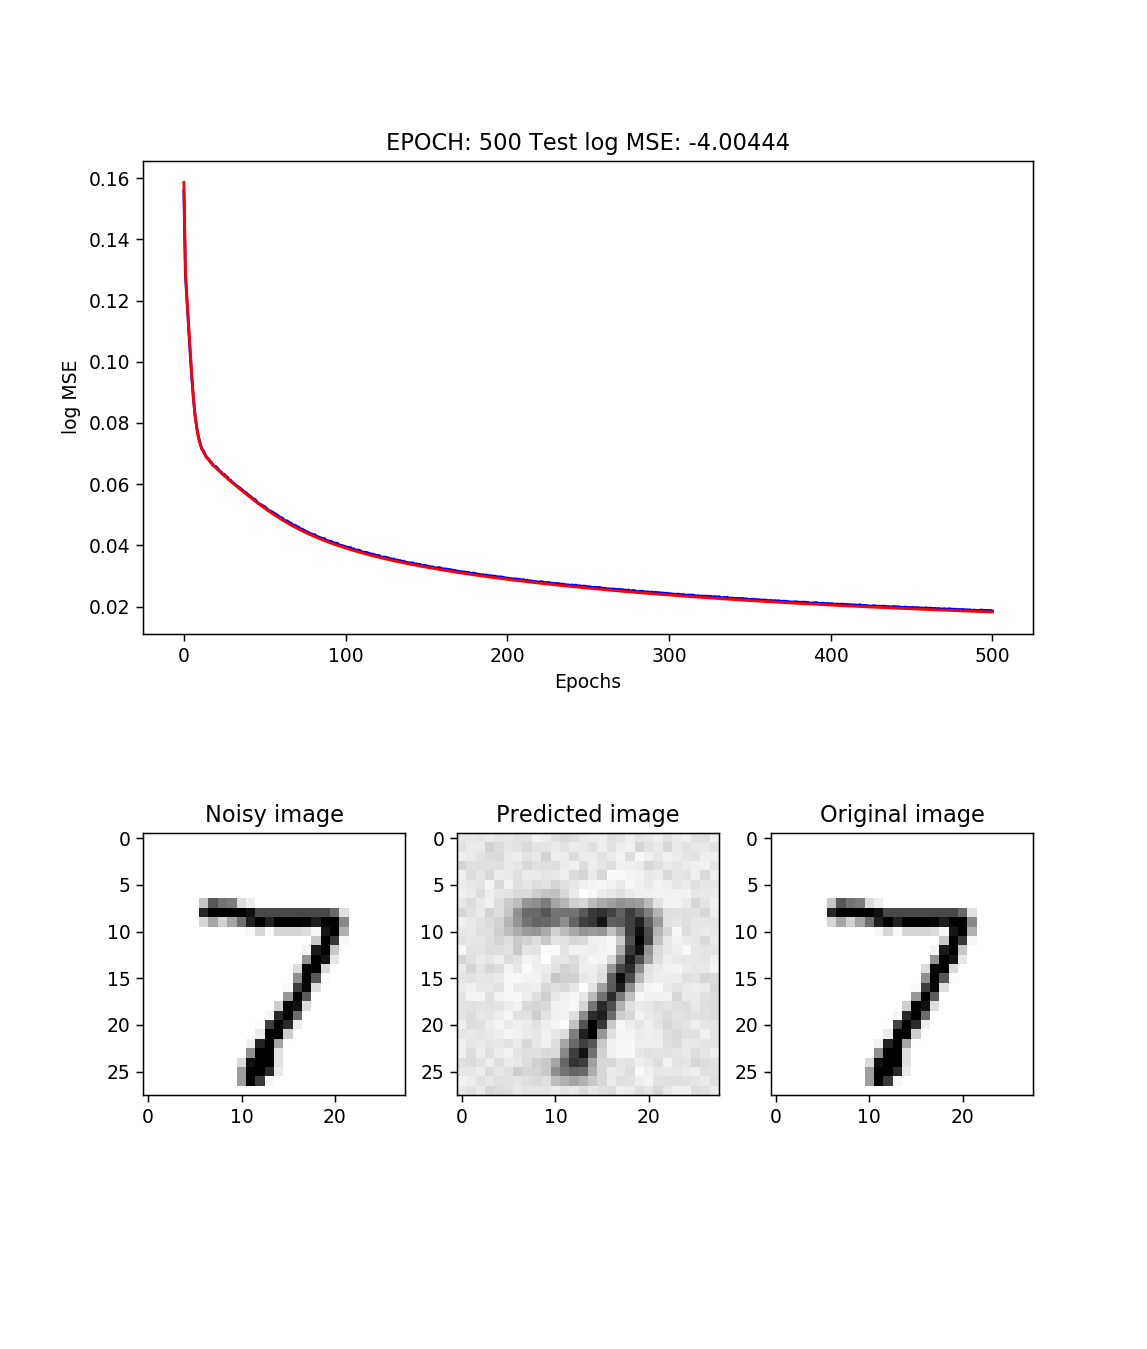

In [9]:
Weights_original = autoencoder(
    image_original_train, image_original_test,
    image_original_train, image_original_test,
    num_epochs, learning_rate, hidden_size,
    early_break_period,
    sample_index
)

<IPython.core.display.Javascript object>


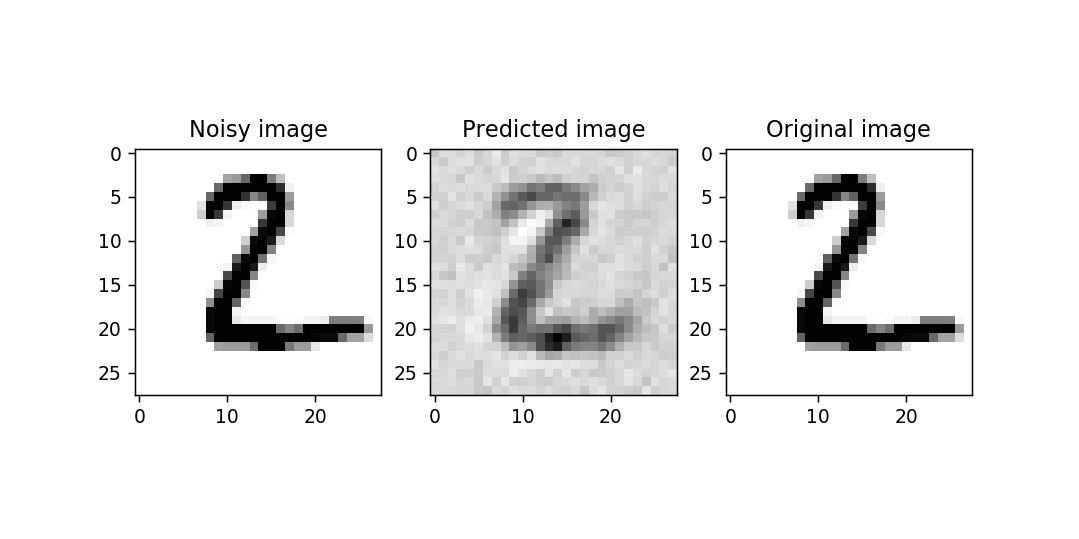

In [17]:
show_prediction(image_original_test, image_original_test, Weights_original, sample_index=1)

<IPython.core.display.Javascript object>


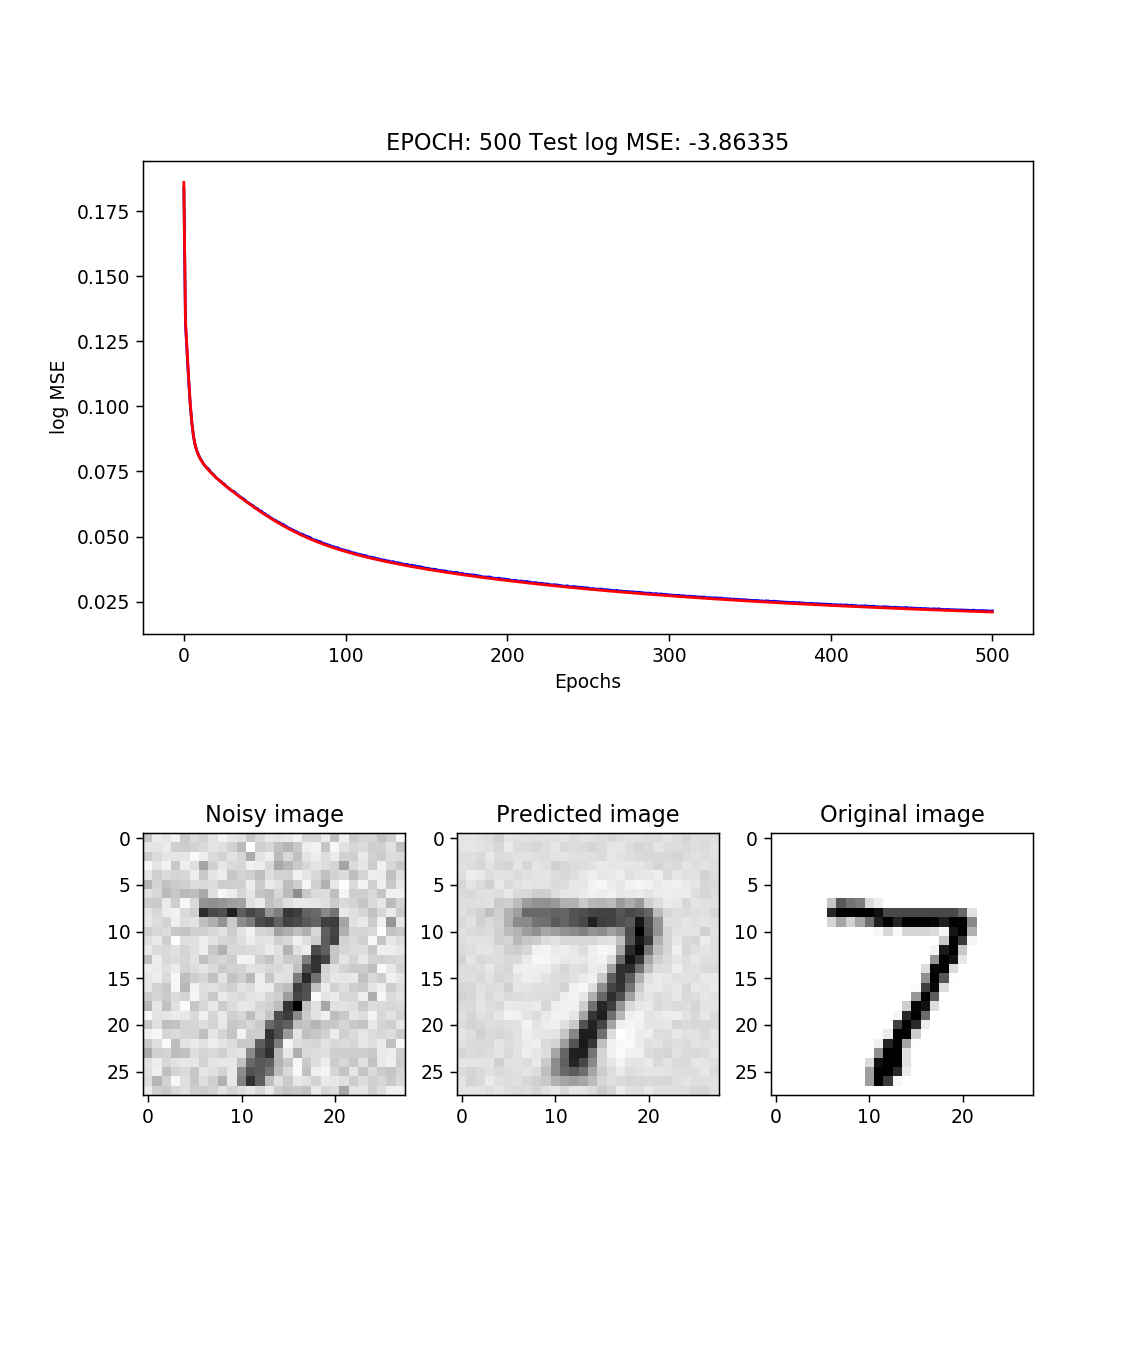

In [11]:
Weights_isotropic_gaussian = autoencoder(
    image_original_train, image_original_test,
    image_isotropic_gaussian_train, image_isotropic_gaussian_test,
    num_epochs, learning_rate, hidden_size,
    early_break_period,
    sample_index
)

<IPython.core.display.Javascript object>


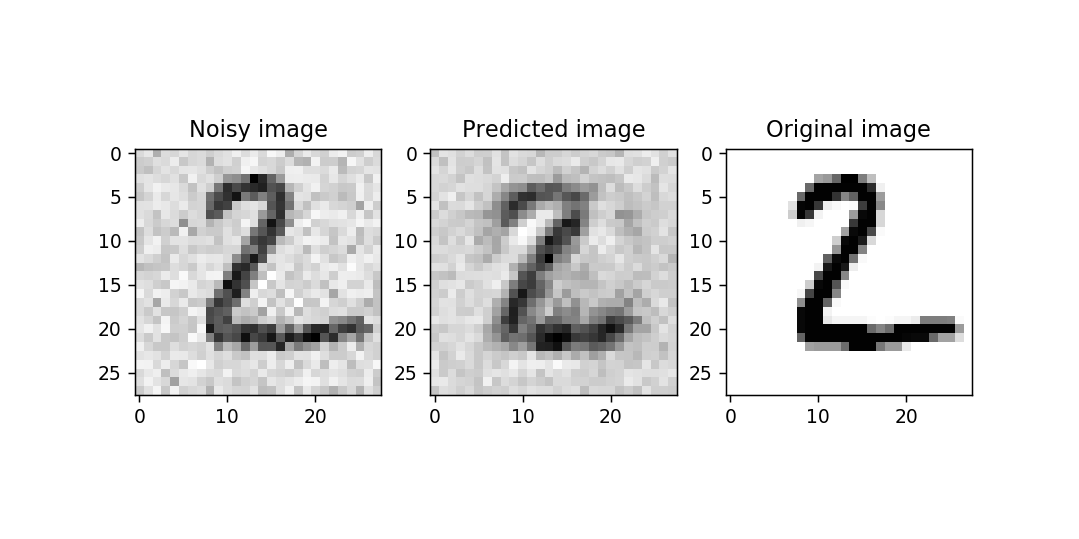

In [12]:
show_prediction(image_original_test, image_isotropic_gaussian_test, Weights_original, sample_index=1)

<IPython.core.display.Javascript object>


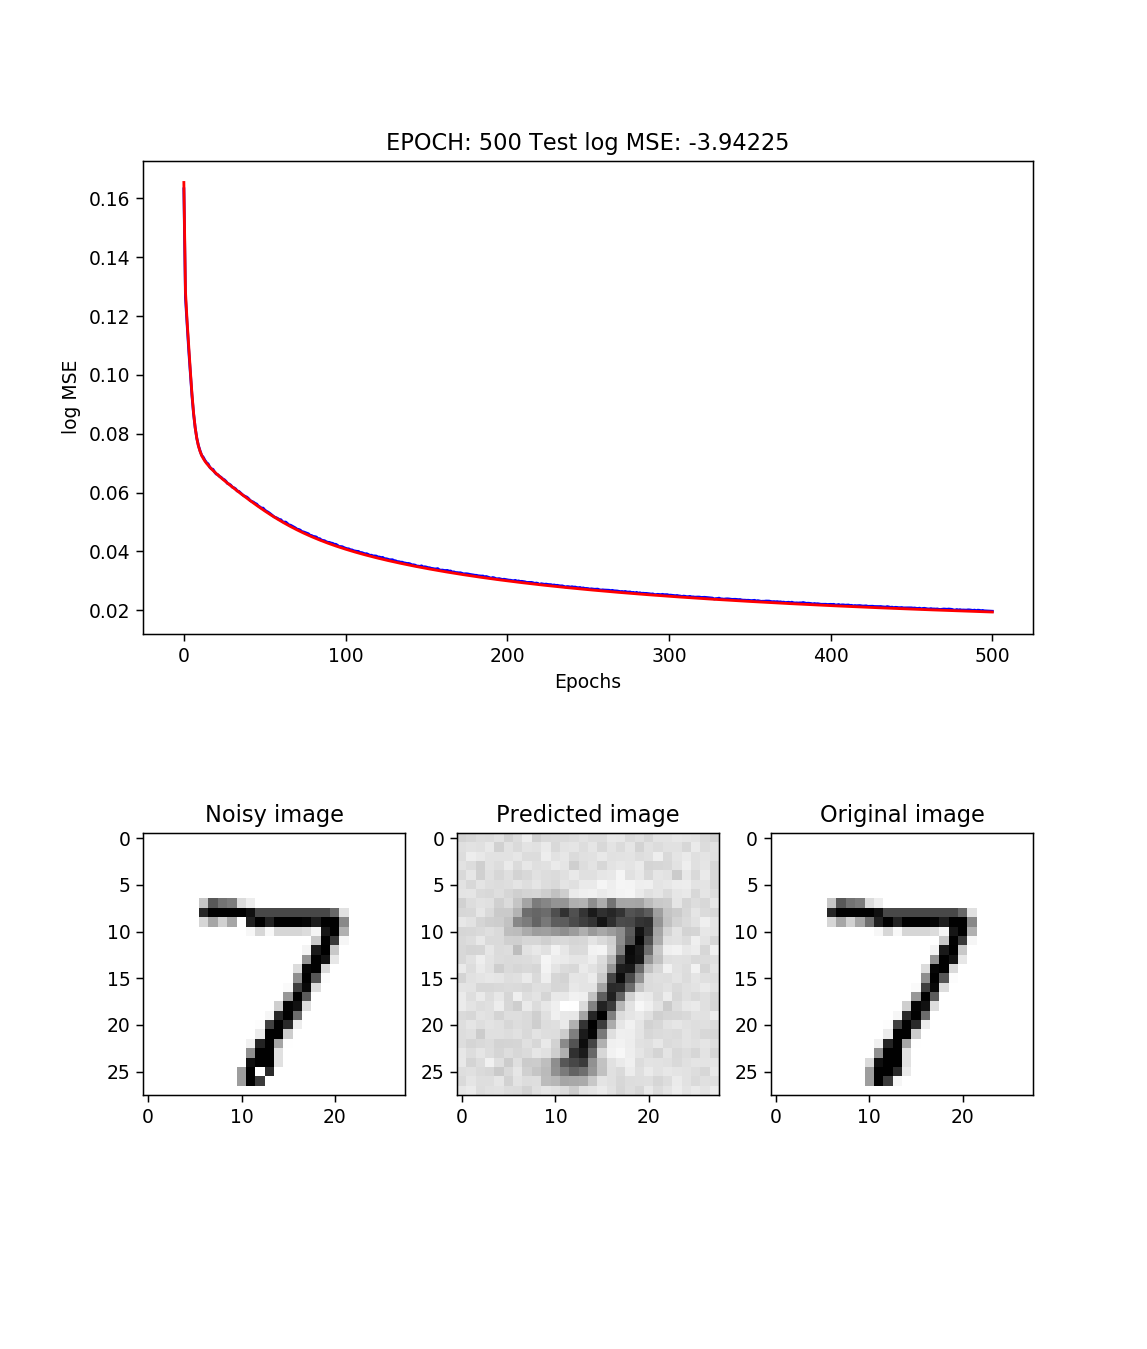

In [13]:
Weights_masking = autoencoder(
    image_original_train, image_original_test,
    image_masking_train, image_masking_test,
    num_epochs, learning_rate, hidden_size,
    early_break_period,
    sample_index
)

<IPython.core.display.Javascript object>


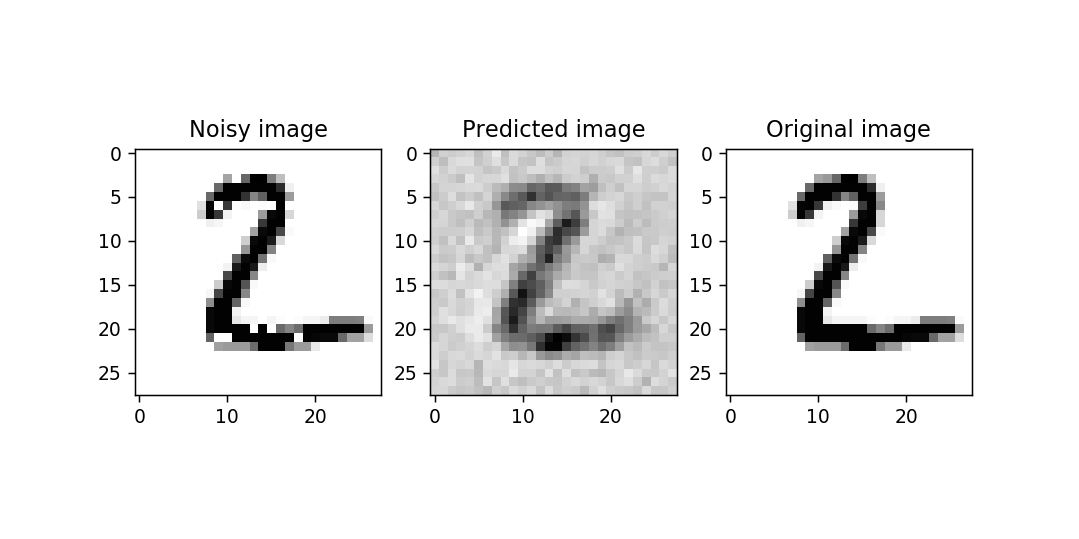

In [18]:
show_prediction(image_original_test, image_masking_test, Weights_original, sample_index=1)

<IPython.core.display.Javascript object>


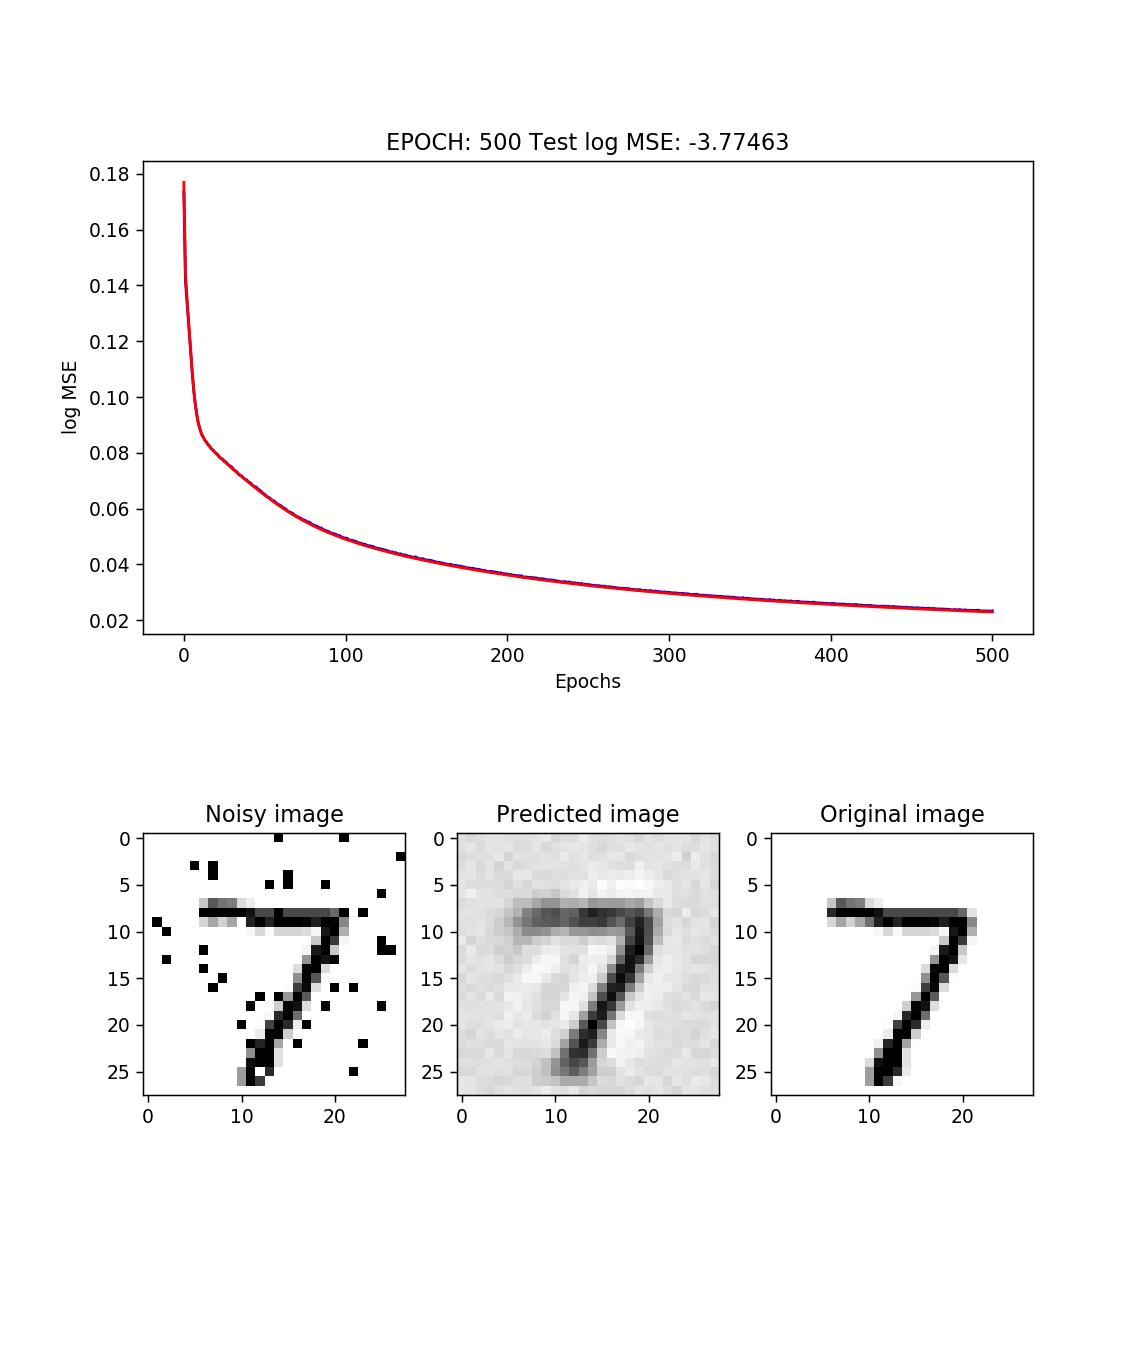

In [15]:
Weights_salt_and_pepper = autoencoder(
    image_original_train, image_original_test,
    image_salt_and_pepper_train, image_salt_and_pepper_test,
    num_epochs, learning_rate, hidden_size,
    early_break_period,
    sample_index
)

<IPython.core.display.Javascript object>


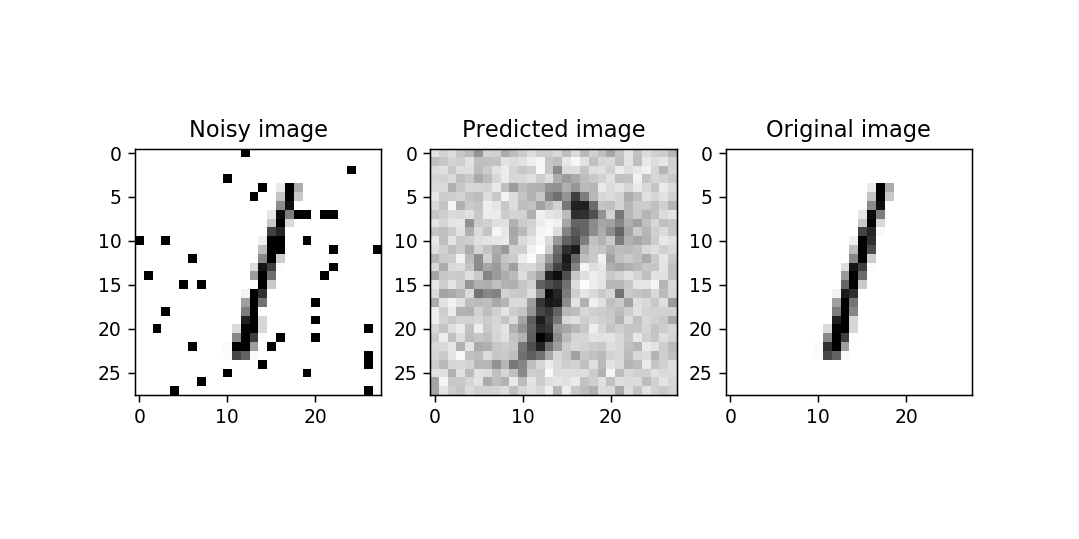

In [22]:
show_prediction(image_original_test, image_salt_and_pepper_test, Weights_original, sample_index=2)

In [20]:
np.save('Weights_original.npz',Weights_original)
np.save('Weights_isotropic_gaussian.npz', Weights_isotropic_gaussian)
np.save('Weights_masking.npz', Weights_masking)
np.save('Weights_salt_and_pepper.npz', Weights_salt_and_pepper)

In [21]:
np.save('Weights_original.npy',Weights_original)
np.save('Weights_isotropic_gaussian.npy', Weights_isotropic_gaussian)
np.save('Weights_masking.npy', Weights_masking)
np.save('Weights_salt_and_pepper.npy', Weights_salt_and_pepper)